In [1]:
import pandas as pd
import numpy as np


In [2]:
train = pd.read_csv("../data/cleaned_train_1.csv")
test = pd.read_csv("../data/cleaned_test_1.csv")

In [3]:
X = train.drop(["Unnamed: 0", "user_id", "MRG", "CHURN"], axis =1)
y = train["CHURN"]

X_test = test.drop(["Unnamed: 0", "user_id", "MRG"], axis = 1)

## SPLITING DATA INTO TRAIN AND VALIDATION SETS

In [4]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 0)

### HELPER FUNCTIONS

In [9]:
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

## Evaluates the model with our validation set and outputs the log loss score
def evaluateModel(model):
    #model = XGBClassifier(n_estimator = est, learning_rate = lr, max_depth = md)
    model.fit(X_train, y_train, 
              eval_set=[(X_val, y_val)],
              
              early_stopping_rounds = 100,
              verbose = 50
             )

## Trains the model on different subset of the dataset and use each to make a prediction
## The predictions across this subset of  the dataset are then averaged
def kfoldPrediction(model, file_name, splits):
    kf = StratifiedKFold(n_splits=splits,shuffle=True)
    #pipe = Pipeline([("scaler", StandardScaler()), ("regressor", model)])
    prediction = np.zeros(len(test))
    for (train_index,test_index) in kf.split(X, y):
        X_train, X_val =X.iloc[train_index],X.iloc[test_index]
        y_train, y_val = y.iloc[train_index],y.iloc[test_index]

        model.fit(X_train,y_train,
                 eval_set=[(X_val, y_val)],
              
              early_stopping_rounds = 100,
              verbose = 50)
        prediction += (model.predict_proba(X_test))[:,1]
    
    prediction = prediction/splits
    pd.DataFrame({"user_id": test["user_id"], "CHURN": prediction}).to_csv("../submission-files/"+file_name, index = False)
    

## Plots the train loss and validation loss
def plot_graphs(train, val, metric):
  plt.plot(train)
  plt.plot(val)
  plt.xlabel("Iterations")
  plt.ylabel(metric)
  plt.legend(["train", "val"])
  plt.show()

In [6]:
cat = CatBoostClassifier(cat_features = ["REGION", "TENURE", "TOP_PACK"], eval_metric='Logloss', n_estimators = 1500, learning_rate = 0.11)
evaluateModel(cat)

0:	learn: 0.5290649	test: 0.5291589	best: 0.5291589 (0)	total: 1.12s	remaining: 27m 53s
50:	learn: 0.2525242	test: 0.2542646	best: 0.2542646 (50)	total: 34.6s	remaining: 16m 22s
100:	learn: 0.2515753	test: 0.2538273	best: 0.2538273 (100)	total: 1m 7s	remaining: 15m 38s
150:	learn: 0.2508293	test: 0.2536171	best: 0.2536170 (149)	total: 1m 41s	remaining: 15m 10s
200:	learn: 0.2501819	test: 0.2535446	best: 0.2535393 (193)	total: 2m 16s	remaining: 14m 43s
250:	learn: 0.2494787	test: 0.2534688	best: 0.2534688 (250)	total: 2m 52s	remaining: 14m 18s
300:	learn: 0.2489876	test: 0.2534396	best: 0.2534170 (284)	total: 3m 26s	remaining: 13m 43s
350:	learn: 0.2485312	test: 0.2534128	best: 0.2533997 (343)	total: 3m 59s	remaining: 13m 3s
400:	learn: 0.2480624	test: 0.2534183	best: 0.2533997 (343)	total: 4m 34s	remaining: 12m 32s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2533997236
bestIteration = 343

Shrink model to first 344 iterations.


#### - Logloss of 0.2533997 on the validation set

In [7]:
results = cat.evals_result_
#results
log_loss_train = results["learn"]["Logloss"]
#log_loss_train
log_loss_val = results["validation"]["Logloss"]

In [23]:
cat = CatBoostClassifier(cat_features = ["REGION", "TENURE", "TOP_PACK"], eval_metric='Logloss', n_estimators = 1500, learning_rate = 0.11)
#kfoldPrediction(cat, "default-cat-1500-011-split-10.csv", 10)
#kfoldPrediction(cat, "default-cat-150-011-split-5.csv", 5)

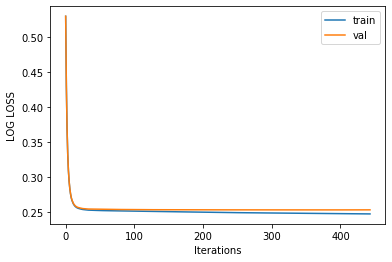

In [8]:
plot_graphs(log_loss_train, log_loss_val, "LOG LOSS")

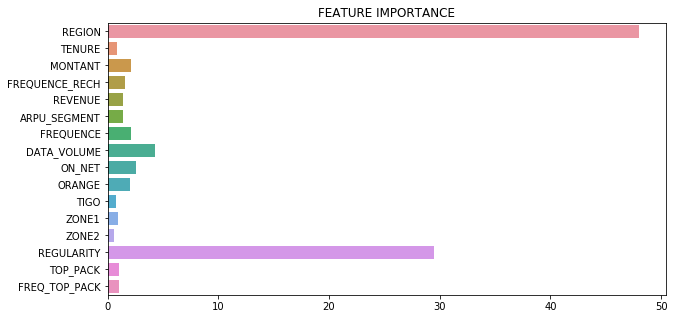

In [14]:
f, ax = plt.subplots(figsize=(10, 5))
plt.title(f"FEATURE IMPORTANCE")
sns.barplot(x = cat.feature_importances_, y=cat.feature_names_)

#### - The "REGION" and "REGULARITY" are the columns that affect our model most when it predicts who CHURN OR NO CHURN

### MAKING PREDICTION AND SAVE TO A SUBMISSION FILE

In [ ]:
cat = CatBoostClassifier(cat_features = ["REGION", "TENURE", "TOP_PACK"], eval_metric='Logloss', n_estimators = 1500, learning_rate = 0.11)
kfoldPrediction(cat, "default-cat-1500-011-split-10.csv", 10)


#### - Gave a score of 0.24716 on the Private LB